## Model Training

Import the Required Libraries/Modules

In [1]:
import numpy as np
import numpy.random as nr
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import to_categorical, plot_model
from keras import backend as K
from time import time
from collections import Counter
from models import ResNet
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
from sklearn import svm, preprocessing
import pyspark

Using TensorFlow backend.


## SVM Traning 

Import FFT data from last stage:

In [15]:
X_train = np.load('./data/X_train_fft.npy')
Y_train = np.load('./data/Y_train_fft.npy')
X_test = np.load('./data/X_val_fft.npy')
y_test = np.load('./data/Y_val_fft.npy')

Models like this work better with scaled data so we fit a standard scaler with our training data

In [16]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)

Now we load and train the saved model and view the configuration it gives us

In [17]:
nr.seed(1115)
filename = './models/svm.sav'
svm_mod = pickle.load(open(filename,'rb'))
svm_mod.fit(X_train, Y_train)

OneVsOneClassifier(estimator=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
          n_jobs=None)

save the trained model

In [ ]:
filename = './models/svm_trained.sav'
pickle.dump(svm_mod, open(filename, 'wb'))

## MLP Neural Network Training 

First we load the FFT data from the last stage:

In [2]:
X_train = np.load('./data/X_train_fft.npy')
Y_train = np.load('./data/Y_train_fft.npy')
X_test = np.load('./data/X_val_fft.npy')
y_test = np.load('./data/Y_val_fft.npy')

Then we scale the training data as we did with the SVM

In [3]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)

We load fit the model with the scaled data

In [4]:
nr.seed(1115)
filename = './models/Neural Network.sav'
nn_mod = pickle.load(open(filename, 'rb'))
nn_mod.fit(X_train, Y_train)

/gpfs/fs01/user/sce8-5e3b8351a3eeda-ba755807525d/.local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [5]:
filename = './models/Neural_Network_trained.sav'
pickle.dump(nn_mod, open(filename, 'wb'))

Already, it is apparent that the model will not give the best predictions due to the convergence warning we received.

## Deep CNN Training (RESNET)

Import the Spectrogram Data from the last stage:

In [29]:
X_train = np.load ('./data/X_train.npy')
Y_train = np.load('./data/Y_train.npy')
X_val = np.load ('./data/X_val.npy')
Y_val = np.load('./data/Y_val.npy')

Create list with classifation categories recognised by the model and all label classes present:

In [30]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']

all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir('data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'eight', 'one', 'happy', 'cat', 'sheila', 'three', 'nine', 'two', 'marvin', 'house', 'dog', 'bird', 'bed', 'tree', 'seven', 'wow', 'six', 'five', 'four', 'zero']


The training data is very unbalanced with a much larger 'unknown' class.
keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [31]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train)


In [37]:
class_weights

{0: 17.0,
 1: 17.0,
 2: 17.0,
 3: 17.0,
 4: 17.0,
 5: 17.0,
 6: 17.0,
 7: 17.0,
 8: 17.0,
 9: 17.0,
 11: 1.0}

Set the input size and the batch size for the CNN model.

In [35]:
input_size = X_train.shape[1:]
batch_size = 196


declare filters for each block of blocks and set output size.

In [39]:
#adjust these strings to set the names of the saved files
date = '0102'
arch = 'resnet8_16_32_Final'

Build the model

In [64]:

from keras.models import load_model
sr = load_model('./models/RESNET.h5')

In [65]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr, 
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [80]:
#callbacks
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

train the model
the history object stores training data for later access, like plotting training curves

In [67]:
history = sr.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 8, 
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer]) # add more callbacks if you want

Train on 57938 samples, validate on 6798 samples
Epoch 1/8
57938/57938 [==============================] - 469s 8ms/step - loss: 7.1657 - acc: 0.4878 - val_loss: 2.4459 - val_acc: 0.4297
Epoch 2/8
57938/57938 [==============================] - 458s 8ms/step - loss: 2.2524 - acc: 0.8163 - val_loss: 1.1925 - val_acc: 0.6814
Epoch 3/8
57938/57938 [==============================] - 461s 8ms/step - loss: 1.5604 - acc: 0.8726 - val_loss: 0.4011 - val_acc: 0.8692
Epoch 4/8
57938/57938 [==============================] - 460s 8ms/step - loss: 1.2932 - acc: 0.8993 - val_loss: 1.8314 - val_acc: 0.5397
Epoch 5/8
57938/57938 [==============================] - 461s 8ms/step - loss: 1.0827 - acc: 0.9168 - val_loss: 0.3756 - val_acc: 0.8817
Epoch 6/8
57938/57938 [==============================] - 466s 8ms/step - loss: 0.9696 - acc: 0.9253 - val_loss: 0.2344 - val_acc: 0.9278
Epoch 7/8
57938/57938 [==============================] - 461s 8ms/step - loss: 0.8924 - acc: 0.9316 - val_loss: 0.3193 - val_acc:

In [69]:
sr.save_weights("./models/{}_{}_last.h5".format(arch, date)) 


plot the training graphs, and save them

['acc', 'loss', 'val_acc', 'val_loss']


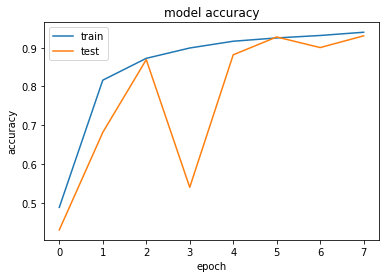

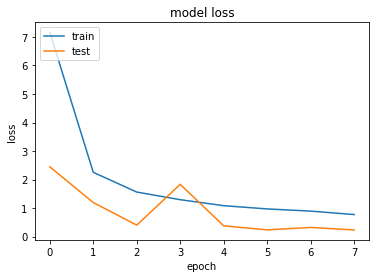

In [75]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
from ibm_botocore.client import Config
import ibm_boto3
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials_1['ENDPOINT'])

save graphs and trained models to COS

In [71]:
cos.upload_file(Filename='models/resnet8_16_32_Final_0102_last.h5',Bucket=credentials_1['BUCKET'],Key='resnet8_16_32_Final_0102_last.h5')
cos.upload_file(Filename='models/Neural_Network_trained.sav',Bucket=credentials_1['BUCKET'],Key='Neural_Network_trained.sav')
cos.upload_file(Filename='models/svm_trained.sav',Bucket=credentials_1['BUCKET'],Key='svm_trained.sav')

In [76]:
cos.upload_file(Filename='graphs/resnet8_16_32_Final_0102_loss.png',Bucket=credentials_1['BUCKET'],Key='graphs/resnet8_16_32_Final_0102_loss.png')
cos.upload_file(Filename='graphs/resnet8_16_32_Final_0102_acc.png',Bucket=credentials_1['BUCKET'],Key='graphs/resnet8_16_32_Final_0102_acc.png')
cos.upload_file(Filename='models/resnet8_16_32_Final_0102.png',Bucket=credentials_1['BUCKET'],Key='models/resnet8_16_32_Final_0102.png')